#     Gaussian Process Regression

Let's begin with importing the required libraries:

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared
)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

# for saving data files
import pandas as pd

In [ ]:
# Initial parameters: vary these to control how many gestures (sets) are used for GPR training, which sets/runs
#  are excluded, and whether DTW is used

# Hard coded from DTW python file: endpt = -100 (future runs will save endpt, so you can extract it from the file)
initialtruncate = -100

doDTW = True
alphaval = 1e-2

endpt = -50 # Empirically determined end of data (cutting off trailing ends)
stepsize = 10

setskipval = 0
# runskipval = 1 # Identify the run that will serve as the test dataset
setrange = 1

for set_num in range(0,setrange):
    for runskipval in range(1,11):
        x,y = load_data(set_num, setskipval, runskipval, doDTW, endpt)
        x_star, y_test = test_set(setskipval, runskipval, doDTW)

        J1_pred_mean, J1_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 0)
        J2_pred_mean, J2_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 1)
        J3_pred_mean, J3_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 2)
        J4_pred_mean, J4_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 3)
        J5_pred_mean, J5_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 4)
        J6_pred_mean, J6_pred_std = GPR_joint_prediction(alphaval, x, y, x_star, 5)

        pred_vals = np.vstack((J1_pred_mean, J2_pred_mean, J3_pred_mean, J4_pred_mean, J5_pred_mean, J6_pred_mean)).T
        std_vals  = np.vstack((J1_pred_std , J2_pred_std , J3_pred_std , J4_pred_std , J5_pred_std , J6_pred_std )).T

        plot_error(pred_vals, std_vals, y_test, setrange, runskipval, alphaval)
        save_error(std_vals, y_test, setrange, runskipval, alphaval)
        plot_prediction(pred_vals, std_vals, y_test, setrange, runskipval, alphaval, set_range)

        #Note: technically, to get a good error analysis, you should repeat 10 times with each run taking a turn being left out for cross-validation
        err_est = 0
        err_act = 0

    for i in range(0,11):
    #     error_data = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")
        error_data = np.load('error_avg_for_Train'+str(setrange-1)+'_leaveoneout_'+str(runskipval)+'_alphaval_'+str(alphaval)+'.npz')    
        err_est = err_est + error_data['error_estimate']
        err_act = err_act + error_data['actual_error']
    print(err_est)
    print(err_act)



RBF Lengthscale: RBF(length_scale=1.56)
RBF Lengthscale: RBF(length_scale=0.263)
RBF Lengthscale: RBF(length_scale=1.05)
RBF Lengthscale: RBF(length_scale=0.648)
RBF Lengthscale: RBF(length_scale=0.232)
RBF Lengthscale: RBF(length_scale=1e+04)
(49, 6)
(49, 6)


In [12]:
def load_data(set_num, setskipval, runskipval, doDTW, endpt):
    # Uncomment the next line when running on Ubuntu, the line following if running on Windows
    # data = np.load("../NonAnthroHands_User_Study/data/positions/positions_"+str(set_num)+"_data/DTW_processed_data/data_"+str(set_num)+"_"+str(run)+".npz")
#     data = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")
#     print(sorted(data.files))

    # if doDTW:
    #     x = np.hstack((data['hand_pos_aligned'][0:endpt:stepsize], data['hand_rot_aligned'][0:endpt:stepsize]))
    #     y = data['joint_data_aligned'][0:endpt:stepsize]
    # else: # Load non-DTW-aligned data
    #     x = data['hand_data'][0:endpt+initialtruncate:stepsize,1:7]
    #     y = data['joint_data_aligned'][0:endpt:stepsize]

    # Initialize data arrays
    x = np.array((0, 0, 0, 0, 0, 0))
    y = np.array((0, 0, 0, 0, 0, 0))

    for set_num in range(0,1):
    #     print("set_num = "+str(set_num))
    #     if set_num==setskipval:
    #         continue
    #     else:
            for run in range (1,11):
                if set_num==setskipval and run==runskipval : 
    #             if run==runskipval : 
                    continue
                else :
        #             print("run="+str(run))
        #             data = np.load("../NonAnthroHands_User_Study/data/positions/positions_"+str(set_num)+"_data/DTW_processed_data/data_"+str(set_num)+"_"+str(run)+".npz")
                    data = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")

                    if doDTW:
                        x_temp = np.hstack((data['hand_pos_aligned'][0:endpt:stepsize], data['hand_rot_aligned'][0:endpt:stepsize]))
                        y_temp = data['joint_data_aligned'][0:endpt:stepsize]
                    else: # Load non-DTW-aligned data
                        x_temp = data['hand_data'][0:endpt+initialtruncate:stepsize,1:7]
                        y_temp = data['joint_data_aligned'][0:endpt:stepsize]

                    x = np.vstack((x,x_temp))
                    y = np.vstack((y,y_temp))

    # Strip unnecessary starting row of zeros from x and y
    x = x[1:-1]
    y = y[1:-1]
    
    return x, y

In [13]:
def test_set(set_num, runskipval, doDTW):
#     set_num=setskipval
#     run=runskipval
    # data = np.load("../NonAnthroHands_User_Study/data/positions/positions_"+str(set_num)+"_data/DTW_processed_data/data_"+str(set_num)+"_"+str(run)+".npz")
    data_test = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(runskipval)+".npz")
    if doDTW:
        x_star = np.hstack((data_test['hand_pos_aligned'][0:endpt:stepsize], data_test['hand_rot_aligned'][0:endpt:stepsize]))
        y_test = data_test['joint_data_aligned'][0:endpt:stepsize]
    else:
        x_star = data_test['hand_data'][0:endpt+initialtruncate:stepsize,1:7]
        y_test = data_test['joint_data_aligned'][0:endpt:stepsize]
    
    return x_star, y_test

In [15]:
def GPR_joint_prediction(alphaval, x, y, x_star, joint):# Construction of Sklearn's Regression and Selection of the Kernel
    kernel = RBF(1,(1e-2,1e4)) # + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e2))   #Good length scale limits seem to lower bound at 0.1, 0.5, or 1.0
    
    gp_regressor = GaussianProcessRegressor(kernel=kernel, alpha=alphaval, normalize_y=True)
#     gp_regressorJ1 = GaussianProcessRegressor(kernel=kernel, alpha=alphaval, normalize_y=True)
#     gp_regressorJ2 = GaussianProcessRegressor(kernel=kernel, alpha=alphaval, normalize_y=True)
#     gp_regressorJ3 = GaussianProcessRegressor(kernel=kernel, alpha=alphaval, normalize_y=True)
#     gp_regressorJ4 = GaussianProcessRegressor(kernel=kernel, alpha=alphaval, normalize_y=True)
#     gp_regressorJ5 = GaussianProcessRegressor(kernel=kernel, alpha=alphaval, normalize_y=True)
#     gp_regressorJ6 = GaussianProcessRegressor(kernel=kernel, alpha=alphaval, normalize_y=True)

    gp_regressor.fit(x,y[:,joint])
#     gp_regressorJ1.fit(x,y[:,0])
#     gp_regressorJ2.fit(x,y[:,1])
#     gp_regressorJ3.fit(x,y[:,2])
#     gp_regressorJ4.fit(x,y[:,3])
#     gp_regressorJ5.fit(x,y[:,4])
#     gp_regressorJ6.fit(x,y[:,5])

    print(f"RBF Lengthscale: {gp_regressor.kernel_}")
#     print(f"RBF Lengthscale: {gp_regressorJ1.kernel_}")
#     print(f"RBF Lengthscale: {gp_regressorJ2.kernel_}")
#     print(f"RBF Lengthscale: {gp_regressorJ3.kernel_}")
#     print(f"RBF Lengthscale: {gp_regressorJ4.kernel_}")
#     print(f"RBF Lengthscale: {gp_regressorJ5.kernel_}")
#     print(f"RBF Lengthscale: {gp_regressorJ6.kernel_}")

    J_pred_mean, J_pred_std = gp_regressor.predict(x_star, return_std=True)
#     J1_pred_mean, J1_pred_std = gp_regressorJ1.predict(x_star, return_std=True)
#     J2_pred_mean, J2_pred_std = gp_regressorJ2.predict(x_star, return_std=True)
#     J3_pred_mean, J3_pred_std = gp_regressorJ3.predict(x_star, return_std=True)
#     J4_pred_mean, J4_pred_std = gp_regressorJ4.predict(x_star, return_std=True)
#     J5_pred_mean, J5_pred_std = gp_regressorJ5.predict(x_star, return_std=True)
#     J6_pred_mean, J6_pred_std = gp_regressorJ6.predict(x_star, return_std=True)


    # df = pd.DataFrame(y_pred_mean)
    # df.to_csv('trained_endeff_mean.csv')
    # df = pd.DataFrame(y_pred_std)
    # df.to_csv('trained_endeff_std.csv')

    return J_pred_mean, J_pred_std

In [37]:
def plot_error(pred_vals, std_vals, y_test, setrange, runskipval, alphaval):
    f = plt.figure(figsize=[17.0, 12.0])

    ax = f.add_subplot(111)
    # labels = ('X','Y','Z')
    labels = ('Joint 1','Joint 2','Joint 3', 'Joint 4', 'Joint 5', 'Joint 6')
    errorlabels = ('Two standard deviations')
    it=0

    # pred_vals = np.vstack((J1_pred_mean, J2_pred_mean, J3_pred_mean, J4_pred_mean, J5_pred_mean, J6_pred_mean)).T
    # std_vals  = np.vstack((J1_pred_std , J2_pred_std , J3_pred_std , J4_pred_std , J5_pred_std , J6_pred_std )).T

    print(pred_vals.shape)
    print(std_vals.shape)

    for i in range(0,6):
        ax.plot(y_test[:,i],label='True '+labels[i]+' angle')

    for i in range(0,6):
        ax.plot(pred_vals[:,i]) #,label='Pred Pos '+labels[i])
    #     if i==3:
    #         ax.plot(np.squeeze(y_pred_mean.T[i]) + y_pred_std, 'k--',label='One STD')
    #     else:
    #         ax.plot(np.squeeze(y_pred_mean.T[i]) + y_pred_std, 'k--')
    #     ax.plot(np.squeeze(y_pred_mean.T[i]) - y_pred_std, 'k--')
        plt.fill_between(
            range(0,std_vals.shape[0]),
            pred_vals[:,i] - 1.96 * std_vals[:,i],
            pred_vals[:,i] + 1.96 * std_vals[:,i],
            alpha=0.5,
            label=r"95% confidence interval for "+ labels[i],
        )

    ax.set_xlabel('X');
    ax.set_ylabel('Y');
    ax.set_title('Predicted vs actual joint angles');
    ax.legend();
    plt.savefig('Error_Train'+str(setrange-1)+'_LeaveOneOut'+str(runskipval)+'_Alpha'+str(alphaval)+'.png')
#     plt.show()
    plt.close('all')

In [33]:
def save_error(std_vals, y_test, setrange, runskipval, alphaval):
    numpts = (std_vals.shape[0]*std_vals.shape[1])
    error_estimate = np.sum(std_vals)/numpts
    print(error_estimate)
    actual_error   = np.sum(np.abs(pred_vals-y_test))/numpts
    print(actual_error)
    np.savez('error_avg_for_Train'+str(setrange-1)+'_leaveoneout_'+str(runskipval)+'_alphaval_'+str(alphaval),error_estimate=error_estimate, actual_error=actual_error)

In [36]:
def plot_prediction(pred_vals, std_vals, y_test, setrange, runskipval, alphaval, set_range):
    # Plotting the Predicted Values
    labels=('1-3','4-6')

    # y_pred_mean, y_pred_std = gp_regressor.predict(x_star, return_std=True)

    for i in range(2):
        fig, ax = plt.subplots(figsize=(15, 10))

        # Show the border and axes ticks
        fig.patch.set_visible(True)
        ax = plt.axes(projection='3d')
        ax.axis('on')
        ax.view_init(-140, 20)
        ax.scatter(y_test[:].T[3*i+0]    , y_test[:].T[3*i+1]      , y_test[:].T[3*i+2],c='skyblue',label='Ground-truth')   #, c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')
        ax.scatter(pred_vals[:].T[3*i+0], pred_vals[:].T[3*i+1], pred_vals[:].T[3*i+2],c='lightcoral',label='Predicted') #, c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector orientation')
        ax.scatter(pred_vals[:].T[3*i+0], pred_vals[:].T[3*i+1], pred_vals[:].T[3*i+2],c='lightcoral', alpha = 0.05, s=std_vals)
        ax.legend()


    # for [map_x, map_y] in warp_path: 
    #     ax.plot3D([y_pred_mean[map_x].T[3*i+0], y_test[map_y].T[3*i+0]], \
    #               [-y_pred_mean[map_x].T[3*i+2], -y_test[map_y].T[3*i+2]],\
    #               [y_pred_mean[map_x].T[3*i+1], y_test[map_y].T[3*i+1]], \
    #               '--k', linewidth=0.2)

        ax.set_xlabel('Joint 1')
        ax.set_ylabel('Joint 2')
        ax.set_zlabel('Joint 3')
        ax.set_title("Comparison of Expected and Actual Joint Angles for joints"+labels[i], fontsize=10, fontweight="bold")

        plt.savefig('GPR_output_'+labels[i]+'Train'+str(setrange-1)+'_leaveoneout_alphaval_'+str(alphaval)+'_run_'+str(runskipval)+'.png')

#         plt.show()
        plt.close('all')

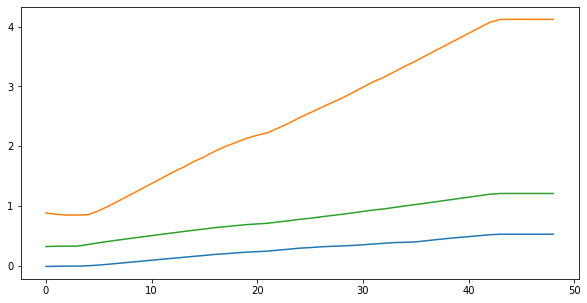

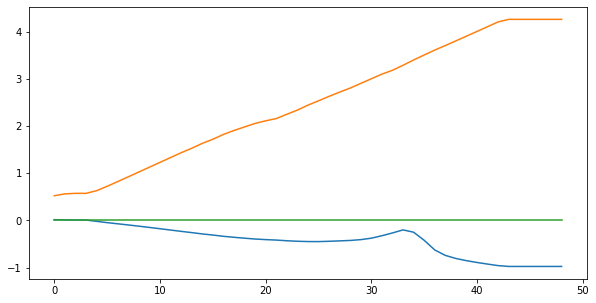

In [96]:
f = plt.figure(figsize=[10.0, 5.0])
ax = f.add_subplot(111)
# ax = plt.axes(projection='3d')
ax.plot(y_test[:,0])
ax.plot(y_test[:,1])
ax.plot(y_test[:,2])
plt.show()
f = plt.figure(figsize=[10.0, 5.0])
ax = f.add_subplot(111)
# ax = plt.axes(projection='3d')
ax.plot(y_test[:,3])
ax.plot(y_test[:,4])
ax.plot(y_test[:,5])

array([[-0.03340571,  0.1388539 ,  0.8950191 ,  0.2791471 ,  0.3454185 ,
         0.3521756 ],
       [-0.03286659,  0.1417115 ,  0.8967065 ,  0.277593  ,  0.3469872 ,
         0.3573287 ],
       [-0.03218451,  0.1505411 ,  0.9000486 ,  0.2779443 ,  0.3468955 ,
         0.3682205 ],
       ...,
       [-0.00434584,  0.08160348,  0.5780332 , -0.0833421 ,  0.9112371 ,
        -0.2344575 ],
       [ 0.00778877,  0.08214363,  0.5904323 , -0.1779695 ,  0.8701562 ,
        -0.2652141 ],
       [ 0.01709509,  0.0842046 ,  0.6038153 , -0.2655278 ,  0.8198322 ,
        -0.277223  ]])